<a href="https://colab.research.google.com/github/DE-Karpov/comaru/blob/develop/comaru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install apyori

!pip install pyfpgrowth

!pip install mlxtend

  Created wheel for apyori: filename=apyori-1.1.2-cp36-none-any.whl size=5977 sha256=cec7cd26c365141519e5ed4be0c09bab168092826b580cc82f6efd09745775b9
  Stored in directory: /root/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori
     |████████████████████████████████| 1.6MB 6.2MB/s 
  Created wheel for pyfpgrowth: filename=pyfpgrowth-1.0-py2.py3-none-any.whl size=5477 sha256=02401507a3cfdd6ab06ccfb11bddaa6067792a4802583c5a764b07f7509487ee
  Stored in directory: /root/.cache/pip/wheels/3b/3f/0d/a04bb8b17887c1eca7d0f1a48d4aa0c09c96eb221ff7fa56c1
Successfully built pyfpgrowth


In [9]:
from apyori import apriori
from google.colab import files
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori as mapriori, fpgrowth, fpmax
import pyfpgrowth
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
uploaded = files.upload()

Saving Basket.csv to Basket.csv


In [3]:
class AssocRules:

    def __init__(self):
        self.dataset = pd.read_csv("Basket.csv", header = None)
        self.transactions = []
        self.fill_transactions()

    def fill_transactions(self):
        for i in range(0, 7501): 
            self.transactions.append([str(self.dataset.values[i,j]) for j in range(0, 20) if not pd.isnull(self.dataset.values[i,j])])    

    class Eclat:

        def __init__(self, min_support = 0.01, max_items = 5, min_items = 2):
            self.min_support = min_support
            self.max_items = max_items
            self.min_items = min_items
            self.item_lst = list()
            self.item_len = 0
            self.item_dict = dict()
            self.final_dict = dict()
            self.data_size = 0
        
        def read_data(self, dataset):
            for index, row in dataset.iterrows():
                row_wo_na = set(row)
                for item in row_wo_na:
                    if pd.isnull(item):
                        continue
                    else:
                        item = item.strip()
                    if item in self.item_dict:
                        self.item_dict[item][0] += 1
                    else:
                        self.item_dict.setdefault(item, []).append(1)
                    self.item_dict[item].append(index)

            self.data_size = dataset.shape[0]
            self.item_lst = list(self.item_dict.keys())
            self.item_len = len(self.item_lst)
            self.min_support = self.min_support * self.data_size
            
        def recur_eclat(self, item_name, tids_array, minsupp, num_items, k_start):
            if tids_array[0] >= minsupp and num_items <= self.max_items:
                for k in range(k_start+1, self.item_len):
                    if self.item_dict[self.item_lst[k]][0] >= minsupp:
                        new_item = item_name + "|" + self.item_lst[k]
                        new_tids = np.intersect1d(tids_array[1:], self.item_dict[self.item_lst[k]][1:])
                        new_tids_size = new_tids.size
                        new_tids = np.insert(new_tids, 0, new_tids_size)
                        if new_tids_size >= minsupp:
                            if num_items >= self.min_items: self.final_dict.update({new_item: new_tids})
                            self.recur_eclat(new_item, new_tids, minsupp, num_items+1, k)
        
        def fit(self, dataset):
            i = 0
            self.read_data(dataset)
            for w in self.item_lst:
                self.recur_eclat(w, self.item_dict[w], self.min_support, 2, i)
                i+=1
            return self
            
        def transform(self):
            return [k[0].split("|") for k in self.final_dict.items()]


    def get_apriori(self, params):
      rules = list(apriori(self.transactions, min_support = params["min_support"], min_confidence = params["min_confidence"], min_lift = params["min_lift"], max_length = params["max_length"]))
      list_of_rules = [list(record.items) for record in rules]
      return list_of_rules

    def get_eclat(self, params):
      model = AssocRules.Eclat(min_support = params["min_support"], max_items = params["max_length"], min_items = 1)
      model.fit(self.dataset)
      return model.transform()

    def get_fpgrowth(self, params):
      support_threshold = int(len(self.transactions) * params['min_support'])
      patterns = pyfpgrowth.find_frequent_patterns(self.transactions, support_threshold)
      new_patterns = {k: v for k, v in patterns.items() if not (("nan") in k)}
      unprepared_list = list(pyfpgrowth.generate_association_rules(new_patterns, params["min_confidence"]))
      prepared_list = [list(item) for item in unprepared_list if len(item) == 2 ]
      return prepared_list

    def user_input_features(self):
      min_support = st.sidebar.slider("Minimal support", 0.01, 0.03, 0.001)
      min_confidence = st.sidebar.slider("Min confidence", 0.2, 0.6, 0.1)
      min_lift = st.sidebar.slider("Lift", 0.5, 6.0, 1.0)
      min_length = st.sidebar.slider("Min length", 1, 2, 3)
      data = {"min_support": min_support,
              "min_confidence": min_confidence,
              "min_lift": min_lift,
              "min_length": min_length}
      features = pd.DataFrame(data, index=[0])
      return features

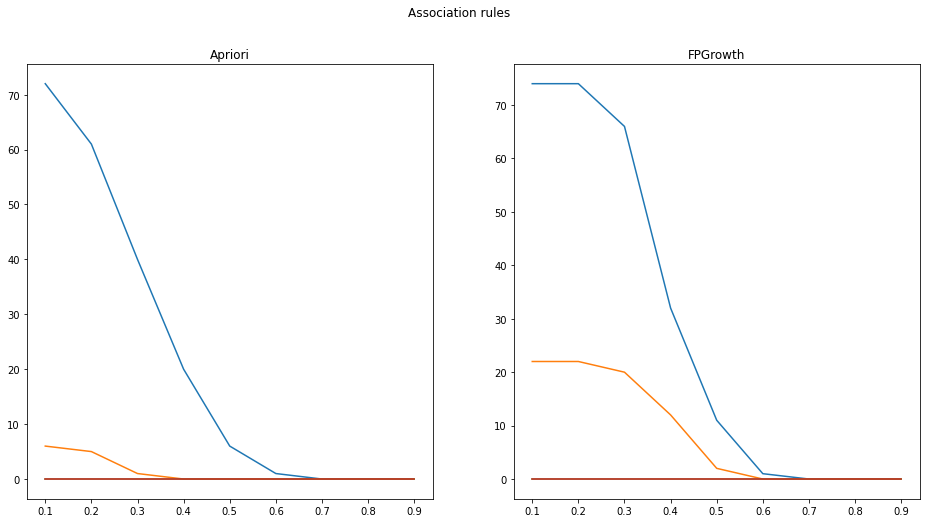

In [7]:
rules = AssocRules()

confidence = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

def gen_rules(min_support, min_lift = 2.4, max_length = None, alg = 'apriori'):
    ap = {}
    common_rules = []
    if alg == 'apriori':
      for i in confidence:
        parameters = {"min_support" : min_support, "min_confidence" : i, "min_lift" : min_lift, "max_length" : max_length}
        apriori_rules = rules.get_apriori(parameters)
        ap[i] = len(apriori_rules)
        common_rules.append(apriori_rules)
    elif alg == 'fpgrowth':
      for i in confidence:
        parameters = {"min_support" : min_support, "min_confidence" : i}
        fpgrowth_rules = rules.get_fpgrowth(parameters)
        ap[i] = len(fpgrowth_rules)
        common_rules.append(fpgrowth_rules)
    return pd.Series(ap).to_frame("Support: %s"%min_support), common_rules

apriori_plot = []
fpgrowth_plot = []
common_rules_plot = []
for i in [0.005,0.01,0.05,0.1]:
    apriori_alg = gen_rules(min_support = i)
    fpgrowth_alg = gen_rules(min_support = i, alg='fpgrowth')
    apriori_plot.append(apriori_alg[0])
    fpgrowth_plot.append(fpgrowth_alg[0])

apriori_all_conf = pd.concat(apriori_plot, axis=1)
fpgrowth_all_conf = pd.concat(fpgrowth_plot, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))
fig.suptitle('Association rules')
ax1.set_title('Apriori')
ax2.set_title('FPGrowth')
ax1.plot(apriori_all_conf)
ax2.plot(fpgrowth_all_conf)

In [ ]:
def getCommonRules(leftRules, rightRules):
  commonRules = []
  print(rightRules)
  for leftSubList in leftRules:
    for rightSubList in rightRules:
      if leftSubList == rightRules:
        commonRules.append(rightRules)
  return commonRules

In [11]:
dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]

In [12]:
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,Apple,Corn,Dill,Eggs,Ice cream,Kidney Beans,Milk,Nutmeg,Onion,Unicorn,Yogurt
0,False,False,False,True,False,True,True,True,True,False,True
1,False,False,True,True,False,True,False,True,True,False,True
2,True,False,False,True,False,True,True,False,False,False,False
3,False,True,False,False,False,True,True,False,False,True,True
4,False,True,False,True,True,True,False,False,True,False,False


In [13]:
fpmax(df, min_support=0.6)

,support,itemsets
0,0.6,"(5, 6)"
1,0.6,"(8, 3, 5)"
2,0.6,"(10, 5)"


In [14]:
fpgrowth(df, min_support=0.6)

,support,itemsets
0,1.0,(5)
1,0.8,(3)
2,0.6,(10)
3,0.6,(8)
4,0.6,(6)
5,0.8,"(3, 5)"
6,0.6,"(10, 5)"
7,0.6,"(8, 3)"
8,0.6,"(8, 5)"
9,0.6,"(8, 3, 5)"


In [15]:
mapriori(df, min_support=0.6)

,support,itemsets
0,0.8,(3)
1,1.0,(5)
2,0.6,(6)
3,0.6,(8)
4,0.6,(10)
5,0.8,"(3, 5)"
6,0.6,"(8, 3)"
7,0.6,"(5, 6)"
8,0.6,"(8, 5)"
9,0.6,"(10, 5)"
